In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys

In [2]:
df = pd.read_csv('Swarm_Behaviour.csv')
df.shape

(23309, 2401)

In [3]:
IMAGES_PATH = os.path.join('./images/')
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
sum(df.isna().sum())

0

In [5]:
df.head()

,x1,y1,xVel1,yVel1,xA1,yA1,xS1,yS1,xC1,yC1,...,yVel200,xA200,yA200,xS200,yS200,xC200,yC200,nAC200,nS200,Swarm_Behaviour
0,562.05,-0.62,-10.70,-4.33,0.00,0.00,0.0,0.0,0.00,0.00,...,-15.15,0.00,0.00,0.00,0.00,0.00,0.0,28,0,0.0
1,175.66,-57.09,2.31,-2.67,0.00,0.00,0.0,0.0,0.00,0.00,...,-3.48,0.00,0.00,0.00,0.00,0.00,0.0,4,0,0.0
2,200.16,-320.07,4.01,-6.37,0.00,0.00,0.0,0.0,0.18,-0.26,...,-9.38,0.00,0.00,0.00,0.00,-0.11,-0.3,15,1,0.0
3,316.99,-906.84,0.85,9.17,-0.17,1.03,0.0,0.0,0.00,0.00,...,10.39,-0.26,1.01,0.00,0.00,0.00,0.0,16,0,0.0
4,1277.68,908.54,-2.02,8.23,-1.00,1.00,0.0,0.0,0.00,0.00,...,13.91,-1.00,0.00,3.21,15.67,0.00,0.0,12,0,0.0


In [6]:
pd.unique(df['Swarm_Behaviour'])

array([0., 1.])

In [7]:
df.dtypes

x1                 float64
y1                 float64
xVel1              float64
yVel1              float64
xA1                float64
                    ...   
xC200              float64
yC200              float64
nAC200               int64
nS200                int64
Swarm_Behaviour    float64
Length: 2401, dtype: object

In [8]:
df.Swarm_Behaviour = df.Swarm_Behaviour.astype(int)
df.dtypes

x1                 float64
y1                 float64
xVel1              float64
yVel1              float64
xA1                float64
                    ...   
xC200              float64
yC200              float64
nAC200               int64
nS200                int64
Swarm_Behaviour      int64
Length: 2401, dtype: object

In [9]:
from sklearn.metrics import classification_report
import random
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict, cross_val_score,train_test_split
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.manifold import TSNE
import time
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LassoCV
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# reshaffling the data

In [10]:
np.random.seed(42)
train = df.sample(frac=1)
Y = train['Swarm_Behaviour']
X = train.drop(['Swarm_Behaviour'],axis=1)
print(X.shape, Y.shape)

(23309, 2400) (23309,)


# Standardize data after training and testing split

In [ ]:
# standardize the test dataset using mean and std from x_train to aviod leaking
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, test_size = 0.2)
mean = x_train.mean()
std = x_train.std()
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

Saving figure dist_sw


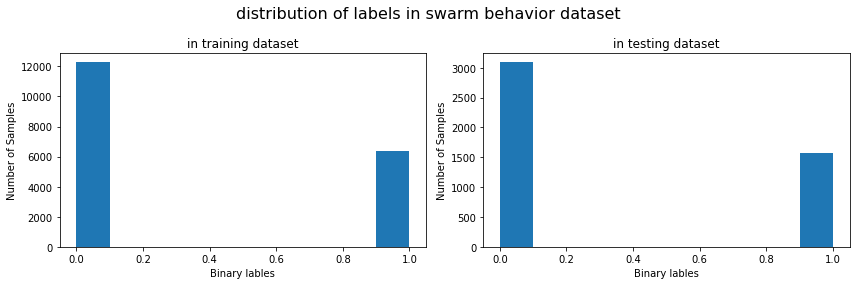

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(12, 4))
fig.suptitle('distribution of labels in swarm behavior dataset', fontsize=16)
axes[0].hist(y_train)
axes[0].title.set_text('in training dataset')
axes[0].set_xlabel("Binary lables")
axes[0].set_ylabel("Number of Samples")
axes[1].set_xlabel("Binary lables")
axes[1].set_ylabel("Number of Samples")
axes[1].hist(y_test)
axes[1].title.set_text('in testing dataset')
save_fig("dist_sw")

# Choosing the number of dimensions to reduce

In [14]:
pca = PCA()
pca.fit(x_train)
#X_reduced = pca.fit_transform(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d
#X_reduced.shape

720

In [15]:
exp_var_pca = pca.explained_variance_ratio_
exp_var_pca

array([1.39699454e-01, 1.13136771e-01, 5.38805267e-02, ...,
       4.73869623e-10, 2.87691491e-10, 1.41239605e-10])

In [16]:
cumsum.shape

(2400,)

Saving figure sw_pca_captured


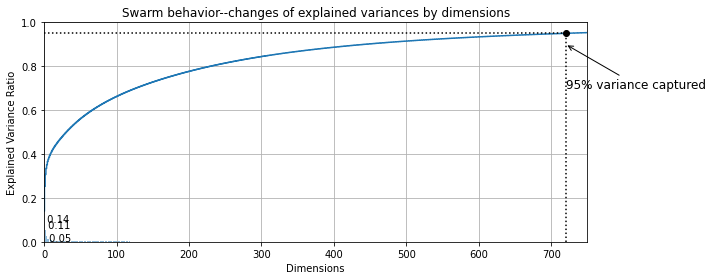

In [33]:
plt.figure(figsize=(10,4))
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cumsum)), cumsum, where='mid',label='Cumulative explained variance')
plt.axis([0, 750, 0, 1])
for i, line in enumerate(exp_var_pca):
    x, y = i, line
    text = ' {:.2f}'.format(y)
    plt.annotate(text, xy=(x+0.05, y-0.05))
plt.xlabel("Dimensions")
#plt.legend(loc='upper right')
plt.ylabel("Explained Variance Ratio")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")

plt.plot(d, 0.95, "ko")
plt.annotate("95% variance captured", xy=(d, 0.90), xytext=(d, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=12)
plt.grid(True)
plt.title("Swarm behavior--changes of explained variances by dimensions")

plt.tight_layout()
save_fig("sw_pca_captured")


# use PCA to visualize high-dimensional dataset

In [19]:
pca = PCA(n_components=3)
df_2D = pca.fit_transform(x_train)


In [20]:
df_2D.shape

(18647, 3)

In [21]:
Y.shape

(23309,)

In [22]:
pca.explained_variance_ratio_

array([0.13969945, 0.11313677, 0.05388053])

In [23]:
df_2D = pd.DataFrame(df_2D)
df_2D['label'] = pd.DataFrame.reset_index(pd.DataFrame(y_train),drop=True)
df_2D = df_2D.rename(columns={0:'PC1',1:'PC2',2:'PC3'})
df_2D.head

<bound method NDFrame.head of              PC1        PC2        PC3  label
0      28.610638   9.735239  -4.891705      0
1     -28.738055   9.166104  -9.555966      0
2     -10.418460 -17.040241  12.137877      1
3     -26.858303   5.830520  -6.371639      0
4     -26.926252 -14.909351   3.601092      0
...          ...        ...        ...    ...
18642  -2.703945  -8.113415  -8.818761      0
18643  30.096152   0.940236   8.858300      1
18644   4.132032  -6.426766  -6.252680      0
18645  -1.983201  -7.964969  -8.279084      0
18646 -28.819362   9.213888  -9.330738      0

[18647 rows x 4 columns]>

In [24]:
df_2D['label'].unique()

array([0, 1])

Saving figure sw_pca_2d


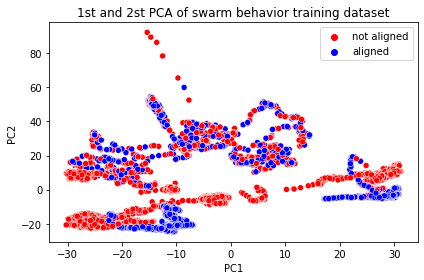

In [25]:
g = sns.scatterplot(x=df_2D['PC1'], y=df_2D['PC2'], hue=df_2D['label'], palette=['r','b'])
legend_labels, _= g.get_legend_handles_labels()
g.legend(legend_labels,['not aligned', 'aligned'])
g.set(title='1st and 2st PCA of swarm behavior training dataset')
save_fig("sw_pca_2d")

#ax.set_xlabel("PC1")
#ax.set_ylabel("PC2")
#ax.legend(loc='upper right')
#ax.set_title("1st and 2st PCA of swarm behavior training dataset")

['[0, 1]']
Saving figure sw_pca_3d


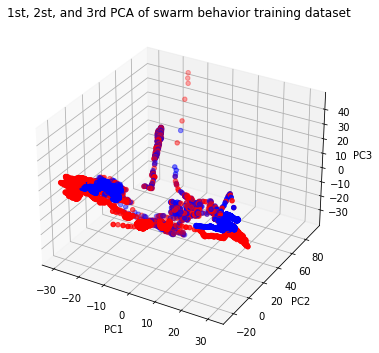

In [27]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

color_dict={0:'r', 1:'b'}
fig = plt.figure(figsize=(6, 5))

ax = plt.subplot(111, projection='3d')

ax.scatter(df_2D['PC1'], df_2D['PC2'], df_2D['PC3'], c = [color_dict[i] for i in df_2D['label']], \
           label=list(i for i in pd.unique(df_2D['label'])))
legend_labels, _= ax.get_legend_handles_labels()
print(_)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title("1st, 2st, and 3rd PCA of swarm behavior training dataset")
#ax.legend()
save_fig("sw_pca_3d")



# Start to train a binary classifier

In [28]:
t0 = time.time()
clf = RandomForestClassifier(max_depth=3, random_state=42)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
t1 = time.time()
time_before_pca = t1-t0
print("Random forest took {:.5f}s.".format(t1 - t0))

Random forest took 8.72148s.


In [35]:
confusion_matrix(y_test, y_pred)

array([[3064,   26],
       [ 408, 1164]])

In [36]:
f1_before_pca = f1_score(y_test, y_pred)
f1_before_pca

0.8428674873280232

In [37]:
pca = PCA(n_components = d)
X_reduced = pca.fit_transform(x_train)
X_test_reduced = pca.fit_transform(x_test)

In [38]:
X_recovered = pca.inverse_transform(X_reduced)
X_recovered

array([[ 0.02070945,  0.1331469 , -0.23716318, ...,  0.91148987,
        -0.37325538,  0.24865301],
       [-1.04590453, -0.72611001, -0.06643342, ..., -0.30550392,
         0.78495086,  0.79247173],
       [ 0.45615889, -0.40821249,  0.33728131, ..., -0.19616323,
        -0.85281904, -0.78546716],
       ...,
       [-0.65511716, -0.52572475, -0.73794346, ..., -0.00497702,
        -0.21791724, -0.82616952],
       [-0.5142469 ,  0.64208336, -0.01133808, ..., -0.09528554,
         0.31342214,  0.26317763],
       [-1.08235201, -0.66880216, -0.00659017, ..., -0.64865384,
         0.79852757,  0.62185971]])

In [39]:
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
result=cosine_similarity(np.asarray(X_recovered).reshape(1,-1),np.asarray(x_train).reshape(1,-1))
result
#1 - sp.distance.cosine(X_recovered, x_train)

array([[0.14664902]])

In [40]:
t0 = time.time()
clf2 = RandomForestClassifier(max_depth=3, random_state=42)
clf2.fit(X_reduced,y_train)
y_pred2=clf2.predict(X_test_reduced)
t1 = time.time()
time_after_pca = t1-t0

print("Random forest took {:.5f}s.".format(t1 - t0))

Random forest took 11.16722s.


In [41]:
confusion_matrix(y_test, y_pred2)

array([[3079,   11],
       [1572,    0]])

In [42]:
f1_after_pca = f1_score(y_test, y_pred2)
f1_after_pca

0.0

In [43]:
f1_variance = (f1_after_pca-f1_before_pca)/f1_before_pca*100
time_variance = (time_after_pca-time_before_pca)/time_before_pca*100


In [44]:
print(f1_variance, time_variance)

-100.0 28.042782327481632


In [45]:
from sklearn.metrics import roc_auc_score

auc_score1 = roc_auc_score(y_test, y_pred)
auc_score2 = roc_auc_score(y_test, y_pred2)

auc_score2

0.4982200647249191

Saving figure sw_roc


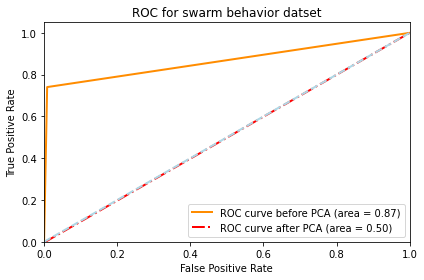

In [46]:
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr[0], tpr[0], _ = roc_curve(y_test, y_pred)
roc_auc[0] = auc(fpr[0], tpr[0])
fpr[1], tpr[1], _ = roc_curve(y_test, y_pred2)
roc_auc[1] = auc(fpr[1], tpr[1])

#fpr["micro1"], tpr["micro1"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
#roc_auc["micro1"] = auc(fpr["micro1"], tpr["micro1"])
#all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
#lw = 1
#mean_tpr = np.zeros_like(all_fpr)
#print(all_fpr)
plt.figure()
lw = 2
plt.plot(
    fpr[0],
    tpr[0],
    color="darkorange",
    lw=lw,
    label="ROC curve before PCA (area = %0.2f)" % roc_auc[0],
)
plt.plot(
    fpr[1],
    tpr[1],
    color="red",
    linestyle='-.',
    lw=lw,
    label="ROC curve after PCA (area = %0.2f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="lightblue", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for swarm behavior datset")
plt.legend(loc="lower right")

save_fig("sw_roc")
